In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from typing import Any
import requests as req
import functools
import pandas as pd
import numpy as np
import tqdm.notebook as tqdm
# from Bio import SeqUtils
import logomaker as lm
from logomaker import Glyph
import itertools
from scipy import stats

In [2]:
BLUE = "#234170"
RED = "#da7a76"
bicolor = sns.color_palette([BLUE, RED])
blue_grad = sns.light_palette(BLUE, as_cmap=True)

In [3]:
res_elim = pd.read_csv('res_elim_w_meta_infos.csv')

In [4]:
res_elim.loc[:, 'plip'] = res_elim.plip.apply(lambda x: [e.replace('\'', '').strip() for e in x[1:-1].split(',')] if isinstance(x, str) else x)
res_elim.loc[:, 'plip'] = res_elim.plip.apply(lambda x: [] if x == [''] else x)
res_elim['#plip'] = res_elim['plip'].map(len)
res_vars = res_elim.groupby(['masked_residue', 'rescode'])[['delta', '#plip', 'klifs_count']].agg(['mean', 'count', 'var']).fillna(0)
res_counts = res_vars.pivot_table(index='masked_residue', columns='rescode').fillna(0)

In [5]:
pl_only = pd.read_csv('mask_pl_edges_at_residue.csv')
pl_only = pl_only[pl_only['model'] == 'CGNN-3D']

In [6]:
len(res_elim), len(pl_only)

(1663343, 1662052)

In [8]:
# sum interactions
klifs_hist = np.array([ 11135,   1530, 212840, 139315,  65620,  53040,   7905,  53125,
        19295,  15640, 204850,      0,   1445,    255, 207315,  40630,
       229160,   1530,  11645,   1445,   4675,      0,   1190,  62050,
         8500,      0,  15895,  66895,    425,      0,  21760,      0,
            0,      0,  22525, 161925,  10455,  24310,      0,      0,
            0,      0,  74800,  22780, 220405, 171275, 299115, 446845,
        93755,  62305, 145860, 129625,      0,   4590,  59415,   4080,
            0,      0,   3145,     85,  21760,      0,      0,     85,
            0,  20230,   7735,  27285,   5100,   5610,      0,   2210,
            0,  62900,  48025,   2805, 216070,      0,  19295, 176205,
       258740, 106845,  15895,  30855,  14535])

In [9]:
highlight_list = (res_elim.groupby('masked_residue')[['delta']].var() > .01).values
res_elim.loc[:, 'res_int'] = [int(highlight_list[res - 1]) for res in res_elim['masked_residue'].values]

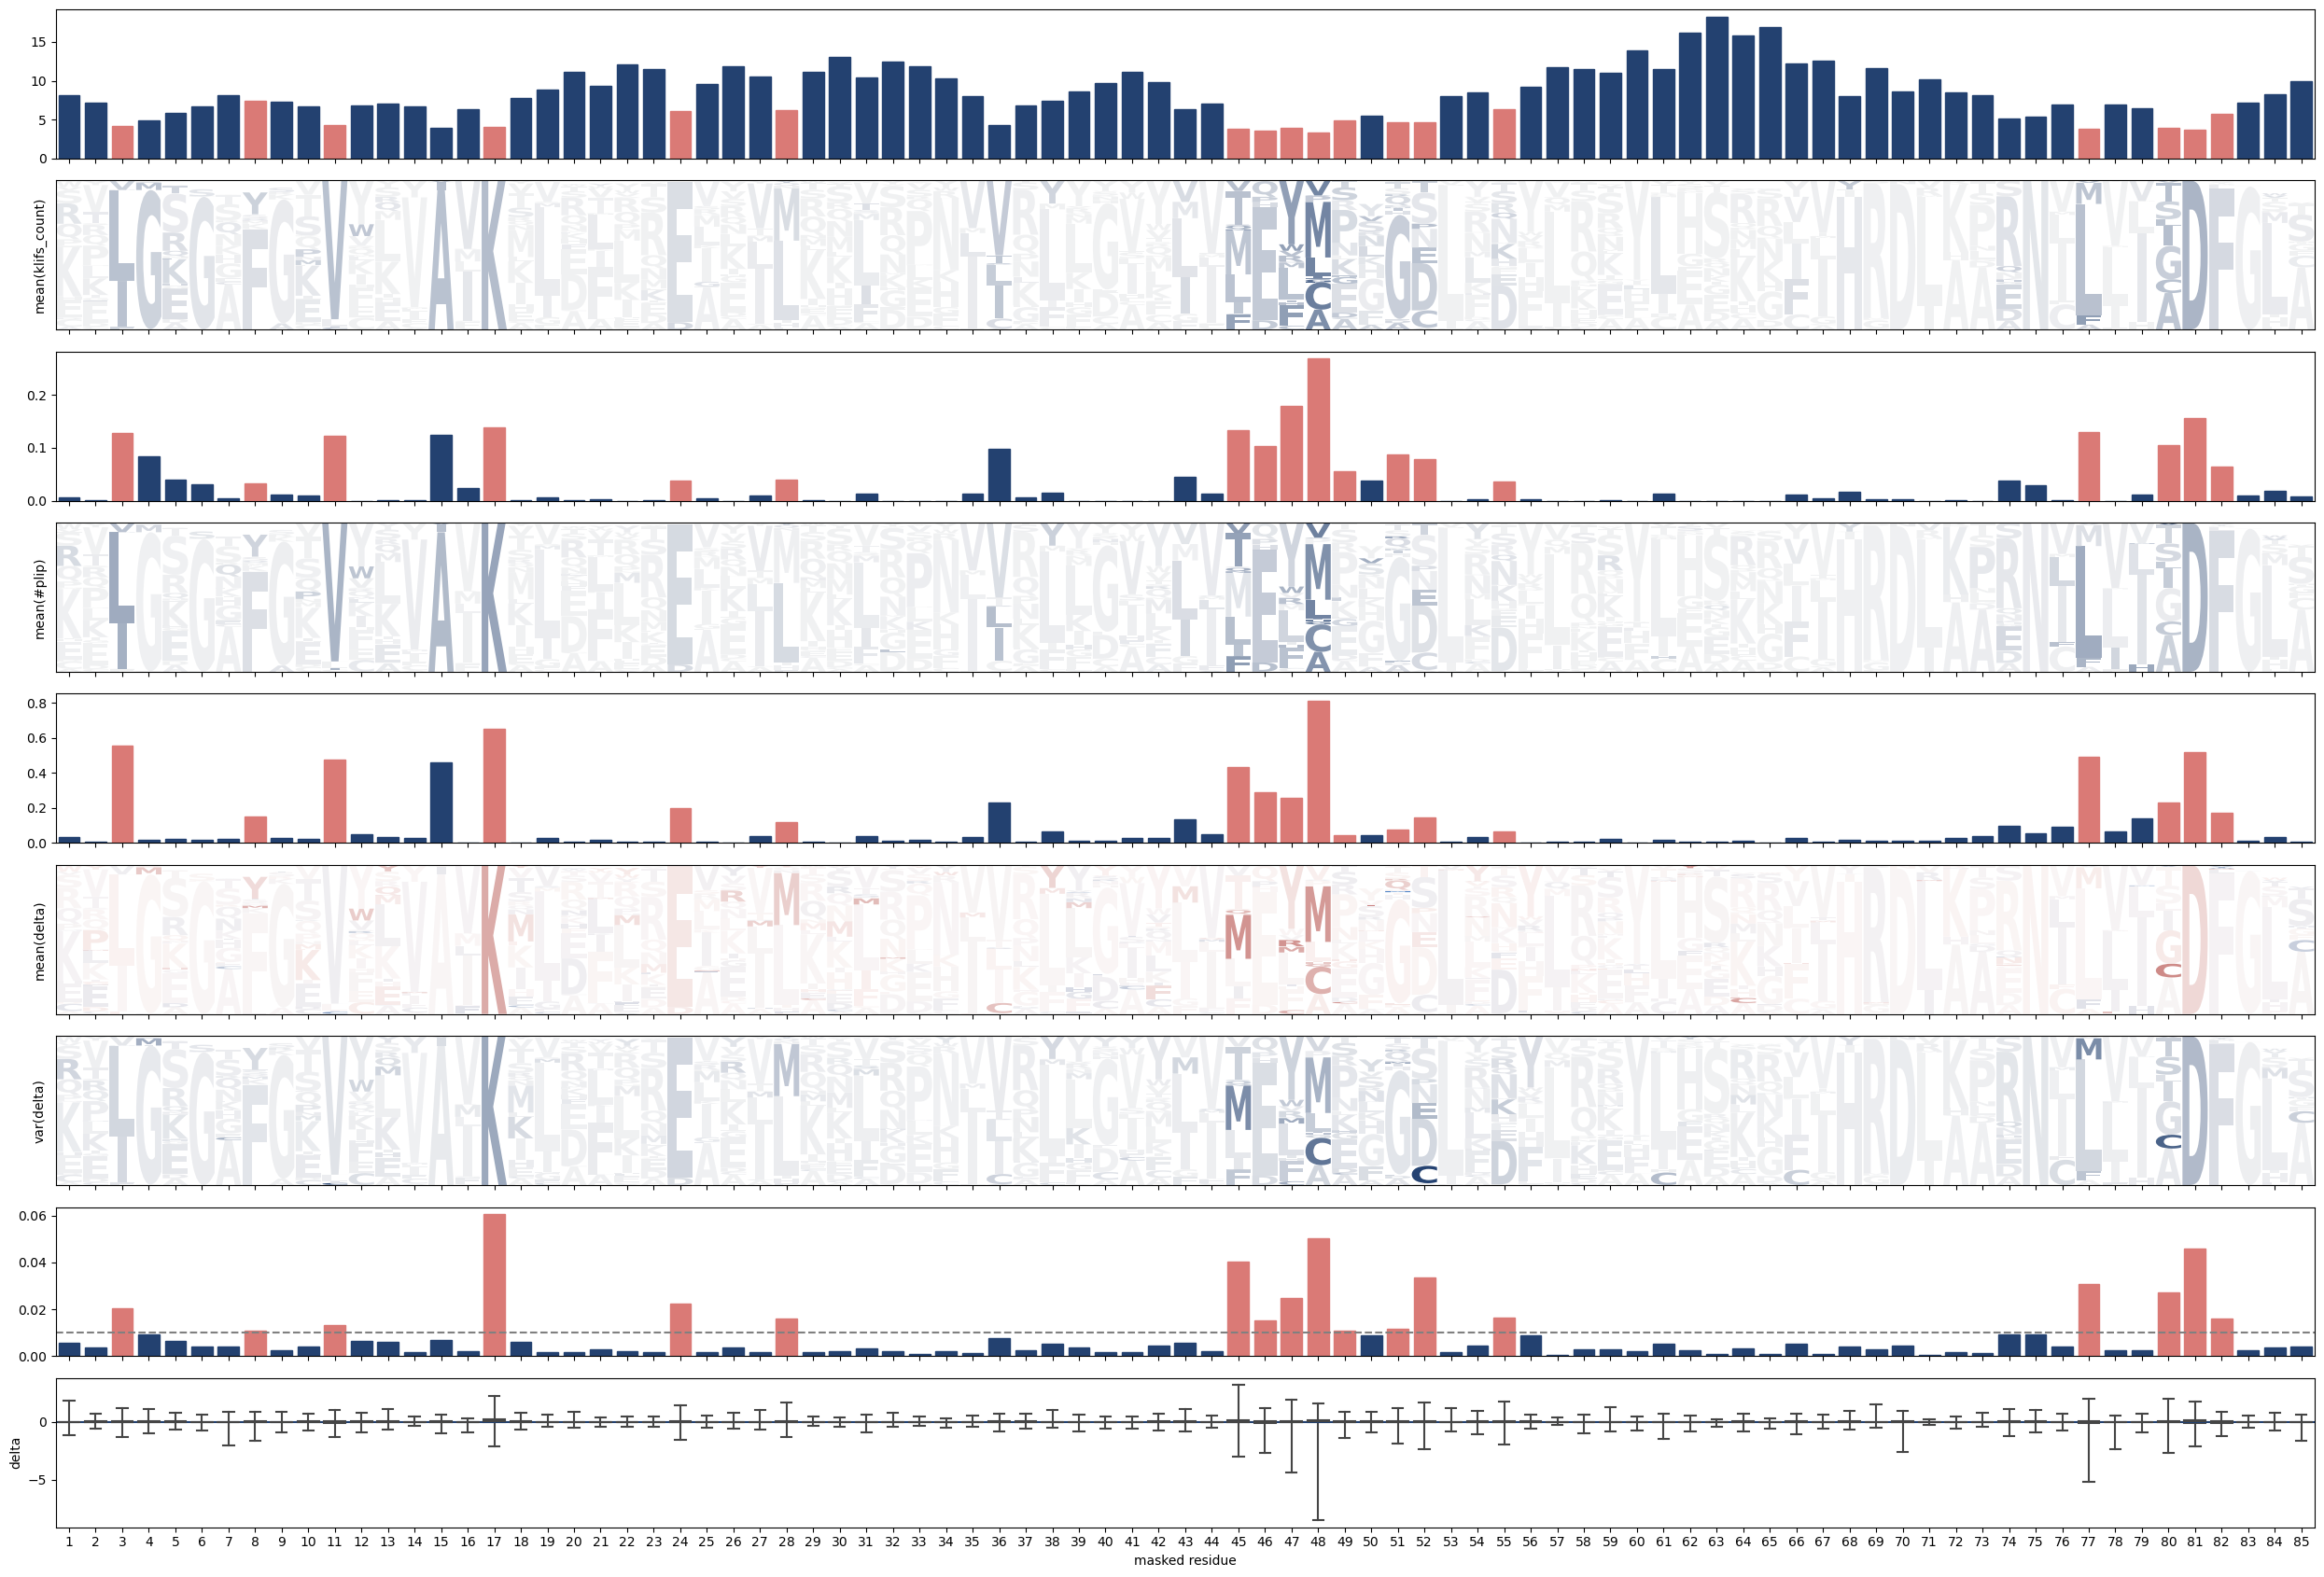

In [18]:
_, (pl_dist_ax, klifs_ax_1, klifs_ax_2, plip_ax_1, plip_ax_2, delta_ax1, delta_ax2, delta_ax3, delta_ax4) = fig, axes = plt.subplots(figsize=(25, 17), nrows=9, sharey=False, sharex=True)

def highlight_interesting(bars):
    for i, bar in enumerate(bars):
        bar.set_color(bicolor[int(highlight_list[i])])

bars = delta_ax3.bar(range(85), res_elim.groupby('masked_residue')['delta'].var())
highlight_interesting(bars)
delta_ax3.plot([-.5, 85.5], [.01] * 2, '--', color='gray')
bars = pl_dist_ax.bar(range(85), res_elim.groupby('masked_residue')['pl_min_dist'].agg('mean'))
highlight_interesting(bars)
bars = plip_ax_2.bar(range(85), res_elim.groupby('masked_residue')['#plip'].agg('mean'))
highlight_interesting(bars)
bars = klifs_ax_2.bar(range(85), klifs_hist / len(res_elim))
highlight_interesting(bars)

sns.boxplot(data=res_elim, y='delta', x='masked_residue', ax=delta_ax4, flierprops=dict(marker='.', markersize=3), whis=(0,100))
delta_ax4.plot([-.5,86], [0,0], c=BLUE)
max_var = res_counts['delta', 'var'].max().max()

max_rescount = res_counts['#plip']['count'].sum(1).max()

def glyphplot(key, key2, ax, max_cnt, c_bias=0, cp=blue_grad):
    for position, values in res_counts.iterrows():
        rescodes = res_counts['delta', 'count'].columns
        floor = 0
        for rescode in rescodes:
            height = values['delta', 'count'][rescode] / max_rescount
            if height == 0:
                continue
            color = cp(values[key, key2][rescode] / max_cnt + c_bias)[:3]
            Glyph(c=rescode, p=position - 1, ceiling=floor+height, floor=floor, ax=ax, color=color)
            floor += height
    ax.set_xlim(-0.5, 84.5)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_ylabel(f'{key2}({key})')


glyphplot('#plip', 'mean', plip_ax_1, res_counts['#plip', 'mean'].max().max())
glyphplot('klifs_count', 'mean', klifs_ax_1, res_counts['klifs_count', 'mean'].max().max())
glyphplot('delta', 'var', delta_ax2, res_counts['delta', 'var'].abs().max().max())
cp = sns.color_palette('vlag', as_cmap=True)
glyphplot('delta', 'mean', delta_ax1, res_counts['delta', 'mean'].abs().max().max(), c_bias=.5, cp=cp)

axes[-1].set_xlabel('masked residue')
axes[-1].set_xticks(np.arange(85))
plt.tight_layout()

# plt.savefig('fullhouse.pdf')

In [16]:
res_elim.columns

Index(['Unnamed: 0', 'activities.activity_id', 'masked_residue', 'level_0',
       'ident', 'masked_pred', 'resname', 'rescode',
       'similar.klifs_structure_id', 'docking.predicted_rmsd',
       'compound_structures.canonical_smiles', 'docking.chemgauss_score',
       'docking.posit_probability', 'UniprotID', 'similar.fp_similarity',
       'index', 'reference_pred', 'target', 'delta', 'pl_min_dist',
       'ca_min_dist', 'klifs_count', 'plip', '#plip', 'res_int'],
      dtype='object')

In [17]:
res_elim.head()

,Unnamed: 0,activities.activity_id,masked_residue,level_0,ident,masked_pred,resname,rescode,similar.klifs_structure_id,docking.predicted_rmsd,...,index,reference_pred,target,delta,pl_min_dist,ca_min_dist,klifs_count,plip,#plip,res_int
0,0,37510,1,974393,10,6.385883,LYS,K,786,1.38455,...,3882,6.364534,5.09691,-0.021349,8.600200,10.684673,0,[],0,0
1,1,37510,2,974397,10,6.425015,VAL,V,786,1.38455,...,3882,6.364534,5.09691,-0.060481,7.226253,8.347977,0,[],0,0
2,2,37510,3,974355,10,6.443994,LEU,L,786,1.38455,...,3882,6.364534,5.09691,-0.079459,3.839240,4.839041,1,[],0,1
3,3,37510,4,974429,10,6.313110,GLY,G,786,1.38455,...,3882,6.364534,5.09691,0.051424,4.134365,4.134365,1,[],0,0
4,4,37510,5,974362,10,6.375696,SER,S,786,1.38455,...,3882,6.364534,5.09691,-0.011161,5.990878,7.418410,0,[],0,0
